In [121]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [122]:
from pycocotools.coco import COCO
import urllib.request
from PIL import Image

In [123]:
coco = COCO('annotations/image_info_test2017.json')

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [124]:
img_ids = coco.getImgIds()

In [125]:
# img_info = coco.loadImgs(img_ids[0])[0]

In [126]:
# for img_id in img_ids[:10]:
#     img_info = coco.loadImgs(img_id)[0]
#     img_url = img_info['coco_url']
#     img_data = urllib.request.urlopen(img_url).read()
#     img = Image.open(urllib.request.urlopen(img_url))
#     img.save(f"img/image_{img_id}.jpg")
#     plt.imshow(img)
#     plt.axis('off')
# plt.show()

Implementation of selective search, guided by 'Selective Search' paper
http://www.huppelen.nl/publications/selectiveSearchDraft.pdf

In [127]:
import cv2
from skimage import segmentation
from collections import defaultdict
from sortedcontainers import SortedList
from copy import deepcopy
import heapq
class SelectiveSearch:
    
    def __init__(self, img):
        self.img = img
        self.segments = self.get_initial_segments()
        self.unique_segments = np.unique(self.segments)
        self.regions = self.extract_regions_from_segments()
        self.last_label = int(self.unique_segments.max())+1
        
        self.imsize = img.shape[0] * img.shape[1]

    def get_initial_segments(self):
        """
        Assigns image pixels to segments according to felzenszwalb
        """
        return segmentation.felzenszwalb(self.img, scale=100, sigma=0.5, min_size=50)
    
    def extract_regions_from_segments(self):
        regions = {}

        neighbors = self.construct_neighboring_segments()
        bboxes = self.get_bounding_boxes()

        for i in self.unique_segments:
            mask = (self.segments == i)
            label = int(i)
            region = {
                'label': label,
                'mask': mask,
                'size': np.sum(mask),
                'color_hist': self.get_color_histogram(mask),
                'texture': self.get_texture_features(mask),
                'bounding_box': bboxes[i],
                'neighbors': neighbors[i]
            }
            regions[label] = region
        return regions
    
    def get_color_histogram(self, mask):
        """
        Get color histogram for a region
        """
        pixels = self.img[mask]
        channel_histograms = np.zeros((3, 25))
        for i in range(3):
            hist, _ = np.histogram(pixels[:, i], bins=25, range=(0, 256))
            hist = hist / (np.sum(hist) + 1e-8)
            channel_histograms[i, :] = hist
        return channel_histograms

    def get_texture_features(self, mask):
        """
        Get texture features using edge/gradient magnitude
        """
        pixels = self.img[mask]
        
        if len(pixels) == 0:
            return np.zeros(10)
        
        # Calc gradients
        gray = np.dot(pixels[..., :3], [0.299, 0.587, 0.114])  # RGB to gray
        
        # Orientation histograms
        hist, _ = np.histogram(gray, bins=10, range=(0, 256))
        return hist / (np.sum(hist) + 1e-8)
        
    
    def construct_neighboring_segments(self):
        neighbors = {i: set() for i in self.unique_segments}
        h, w = self.segments.shape

        for i in range(1, h-1):
            for j in range(1, w-1):
                seg = int(self.segments[i, j])

                for dx in (-1, 0, 1):
                    for dy in (-1, 0, 1):
                        if dx == 0 and dy == 0:
                            continue
                        nseg = int(self.segments[i+dx, j+dy])

                        if seg != nseg:
                            neighbors[seg].add(nseg)
                            neighbors[nseg].add(seg)
                        

        return neighbors
    
    def get_bounding_boxes(self):
        h, w = self.segments.shape
        
        bboxes = { i: [h, 0, w, 0] for i in self.unique_segments} #[y_min, y_max, x_min, x_max]

        for i in range(h):
            for j in range(w):
                seg = int(self.segments[i, j])
                ymin, ymax, xmin, xmax = bboxes[seg]
                bboxes[seg] = (min(ymin, i), max(ymax, i), min(xmin, j), max(xmax, j))

        return bboxes
    
    def color_similarity(self, r1, r2):
        """
        Compute color similarity between two regions
        """
        c1 = self.regions[r1]['color_hist']
        c2 = self.regions[r2]['color_hist']
        return np.minimum(c1, c2).sum()
    
    def texture_similarity(self, r1, r2):
        """
        Compute color similarity between two regions
        """
        c1 = self.regions[r1]['texture']
        c2 = self.regions[r2]['texture']
        return np.minimum(c1, c2).sum()
    
    def size_similarity(self, r1, r2):
        """
        Compute size similarity between two regions
        """
        s1 = self.regions[r1]['size']
        s2 = self.regions[r2]['size']
        return 1 - (s1 + s2) / self.imsize
    
    def fill_similarity(self, r1, r2):
        s1 = self.regions[r1]['size']
        s2 = self.regions[r2]['size']

        bb1 = self.regions[r1]['bounding_box']
        bb2 = self.regions[r2]['bounding_box']

        tight_bb = (
            min(bb1[0], bb2[0]), max(bb1[1], bb2[1]), 
            min(bb1[2], bb2[2]), max(bb1[3], bb2[3])
        )

        h, w = tight_bb[1] - tight_bb[0], tight_bb[3] - tight_bb[2]
        bb_size = h*w

        return 1 - (bb_size - s1 - s2) / (self.imsize)
    
    def similarity(self, r1, r2):
        s1 = self.color_similarity(r1, r2)
        s2 = self.fill_similarity(r1, r2)
        s3 = self.texture_similarity(r1, r2)
        s4 = self.size_similarity(r1, r2)

        return s1 + s2 + s4
    
    def merge_regions(self, r1, r2, regions):
        d1, d2 = regions[r1], regions[r2]
        s1, s2 = d1['size'], d2['size']
        c1, c2 = d1['color_hist'], d2['color_hist']
        b1, b2 = d1['bounding_box'], d2['bounding_box']
        t1, t2 = d1['texture'], d2['texture']
        n1, n2 = d1['neighbors'], d2['neighbors']

        new_size = s1+s2
        new_label = self.last_label
        self.last_label+=1
        new_region = {
            'label': new_label,
            'mask': d1['mask'] | d2['mask'],
            'size': new_size,
            'color_hist': (s1*c1 + s2*c2) / new_size,
            'texture': (s1*t1 + s2*t2) / new_size,
            'bounding_box': (min(b1[0], b2[0]), max(b1[1], b2[1]), min(b1[2], b2[2]), max(b1[3], b2[3])),
            'neighbors': ( n1 | n2 ) - { r1, r2 }

        }
        return new_region
    
    def hierarchical_grouping(self):
        # regions = {i: deepcopy(self.regions[i]) for i in range(len(self.regions))}
        regions = self.regions.copy()
        active_regions = set(self.unique_segments)
        similarities = []
        timestamp = 0
        merged_into = {}
        candidates = []

        for i in range(len(regions)):
            for neighbor in regions[i]['neighbors']:
                if i < neighbor:
                    sim = self.similarity(i, neighbor)
                    similarities.append((-sim, timestamp, i, neighbor))
                    timestamp+=1
        
        #Sorted by decreasing similarity
        heapq.heapify(similarities)

        while similarities:
            neg_sim, _, r1, r2 = heapq.heappop(similarities)

            r1 = merged_into.get(r1, r1)
            r2 = merged_into.get(r2, r2)

            if r1 == r2 or r1 not in active_regions or r2 not in active_regions:
                continue

            merged_region = self.merge_regions(r1, r2, regions)
            new_label = merged_region['label']

            merged_into[r1] = new_label
            merged_into[r2] = new_label

            del regions[r1]
            del regions[r2]
            active_regions.discard(r1)
            active_regions.discard(r2)

            regions[new_label] = merged_region
            active_regions.add(new_label)

            # #The idea is to include only at least mediocre similarities 
            # if neg_sim < -0.25:  #Negative, avoid getting it positive just for this
            candidates.append(merged_region)

            for n in merged_region['neighbors']:
                neighbor = merged_into.get(n, n)

                if neighbor in active_regions and new_label < neighbor:
                    sim = self.similarity(new_label, neighbor)
                    heapq.heappush(similarities, (-sim, timestamp, new_label, neighbor))
                    timestamp += 1
        self.candidates = candidates
        return candidates


        

In [128]:
img = mpimg.imread('img/image_579853.jpg')
# from skimage import data
# img = data.coffee()

In [129]:
img.shape

(359, 640, 3)

(np.float64(-0.5), np.float64(639.5), np.float64(358.5), np.float64(-0.5))

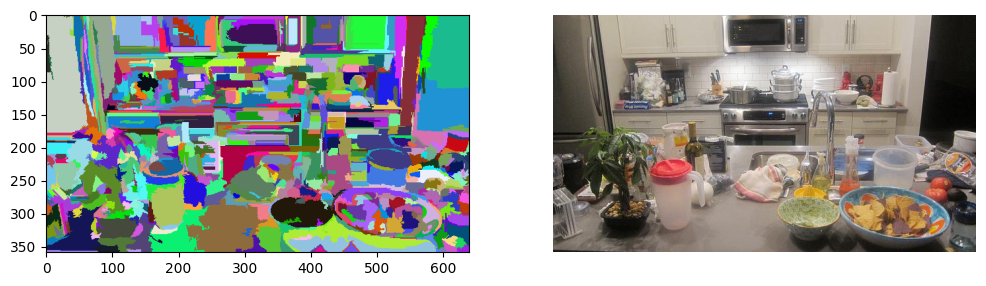

In [130]:
sel_search = SelectiveSearch(img)

h, w = sel_search.segments.shape
image_colored = np.zeros((h, w, 3), dtype='uint8')
for i in np.unique(sel_search.segments):
    mask = (sel_search.segments == i)
    image_colored[mask] = np.random.randint(0, 256, 3)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(image_colored)
axes[1].imshow(img)
plt.axis('off')

In [131]:
sel_search.img.shape

(359, 640, 3)

In [132]:
candidates = sel_search.hierarchical_grouping()

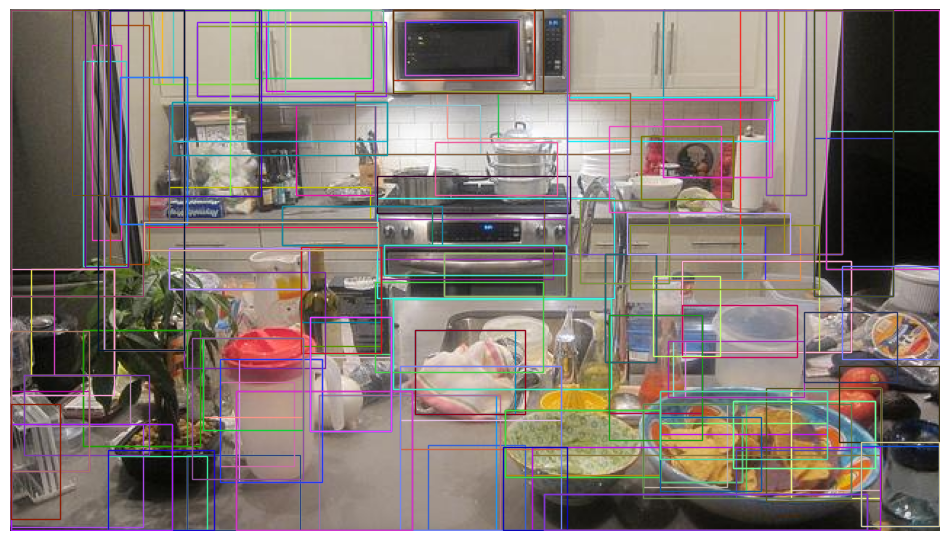

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(img)

for candidate in candidates:
    bbox = candidate['bounding_box']
    y_min, y_max, x_min, x_max = bbox
    h = x_max - x_min
    w = y_max - y_min
    if h*w < 2500:
        continue
    rect = plt.Rectangle((x_min, y_min), h, w, 
                         fill=False, edgecolor=np.random.rand(3,), linewidth=1)
    ax.add_patch(rect)

plt.axis('off')
plt.show()

In [ ]:
from skimage import segmentation
import heapq
class SelectiveSearch2:
    
    def __init__(self, img):
        self.img = img
        self.img_flatten = self.img.reshape(-1, 3)
        self.segments = self.get_initial_segments()
        self.unique_segments = np.unique(self.segments)
        self.regions = self.extract_regions_from_segments()
        self.last_label = int(self.unique_segments.max())+1
        
        self.imsize = img.shape[0] * img.shape[1]

    def get_initial_segments(self):
        """
        Assigns image pixels to segments according to felzenszwalb
        """
        return segmentation.felzenszwalb(self.img, scale=100, sigma=0.5, min_size=50)
    
    def extract_regions_from_segments(self):
        regions = {}

        neighbors = self.construct_neighboring_segments()
        bboxes = self.get_bounding_boxes()

        for i in self.unique_segments:
            indices = np.where(self.segments == i)[0]
            label = int(i)
            region = {
                'label': label,
                'indices': indices,
                'size': len(indices),
                'color_hist': self.get_color_histogram(indices),
                'texture': self.get_texture_features(indices),
                'bounding_box': bboxes[i],
                'neighbors': neighbors[i]
            }
            regions[label] = region
        return regions
    
    def get_color_histogram(self, indices):
        """
        Get color histogram for a region
        """
        pixels = self.img_flatten[indices]
        channel_histograms = np.zeros((3, 25))
        for i in range(3):
            hist, _ = np.histogram(pixels[:, i], bins=25, range=(0, 256))
            hist = hist / (np.sum(hist) + 1e-8)
            channel_histograms[i, :] = hist
        return channel_histograms

    def get_texture_features(self, indices):
        """
        Get texture features using edge/gradient magnitude
        """
        pixels = self.img_flatten[indices]
        
        if len(pixels) == 0:
            return np.zeros(10)
        
        # Calc gradients
        gray = np.dot(pixels[..., :3], [0.299, 0.587, 0.114])  # RGB to gray
        
        # Orientation histograms
        hist, _ = np.histogram(gray, bins=10, range=(0, 256))
        return hist / (np.sum(hist) + 1e-8)
        
    
    def construct_neighboring_segments(self):
        neighbors = {i: set() for i in self.unique_segments}
        h, w = self.segments.shape

        for i in range(1, h-1):
            for j in range(1, w-1):
                seg = int(self.segments[i, j])

                for dx in (-1, 0, 1):
                    for dy in (-1, 0, 1):
                        if dx == 0 and dy == 0:
                            continue
                        nseg = int(self.segments[i+dx, j+dy])

                        if seg != nseg:
                            neighbors[seg].add(nseg)
                            neighbors[nseg].add(seg)
                        

        return neighbors
    
    def get_bounding_boxes(self):
        h, w = self.segments.shape
        
        bboxes = { i: [h, 0, w, 0] for i in self.unique_segments} #[y_min, y_max, x_min, x_max]

        for i in range(h):
            for j in range(w):
                seg = int(self.segments[i, j])
                ymin, ymax, xmin, xmax = bboxes[seg]
                bboxes[seg] = (min(ymin, i), max(ymax, i), min(xmin, j), max(xmax, j))

        return bboxes
    
    def color_similarity(self, r1, r2):
        """
        Compute color similarity between two regions
        """
        c1 = self.regions[r1]['color_hist']
        c2 = self.regions[r2]['color_hist']
        return np.minimum(c1, c2).sum()
    
    def texture_similarity(self, r1, r2):
        """
        Compute color similarity between two regions
        """
        c1 = self.regions[r1]['texture']
        c2 = self.regions[r2]['texture']
        return np.minimum(c1, c2).sum()
    
    def size_similarity(self, r1, r2):
        """
        Compute size similarity between two regions
        """
        s1 = self.regions[r1]['size']
        s2 = self.regions[r2]['size']
        return 1 - (s1 + s2) / self.imsize
    
    def fill_similarity(self, r1, r2):
        s1 = self.regions[r1]['size']
        s2 = self.regions[r2]['size']

        bb1 = self.regions[r1]['bounding_box']
        bb2 = self.regions[r2]['bounding_box']

        tight_bb = (
            min(bb1[0], bb2[0]), max(bb1[1], bb2[1]), 
            min(bb1[2], bb2[2]), max(bb1[3], bb2[3])
        )

        h, w = tight_bb[1] - tight_bb[0], tight_bb[3] - tight_bb[2]
        bb_size = h*w

        return 1 - (bb_size - s1 - s2) / (self.imsize)
    
    def similarity(self, r1, r2):
        s1 = self.color_similarity(r1, r2)
        s2 = self.fill_similarity(r1, r2)
        s3 = self.texture_similarity(r1, r2)
        s4 = self.size_similarity(r1, r2)

        return s1 + s2 + s4
    
    def merge_regions(self, r1, r2, regions):
        d1, d2 = regions[r1], regions[r2]
        s1, s2 = d1['size'], d2['size']
        c1, c2 = d1['color_hist'], d2['color_hist']
        b1, b2 = d1['bounding_box'], d2['bounding_box']
        t1, t2 = d1['texture'], d2['texture']
        n1, n2 = d1['neighbors'], d2['neighbors']

        new_size = s1+s2
        new_label = self.last_label
        self.last_label+=1
        new_region = {
            'label': new_label,
            'indices': np.unique(np.concatenate([d1['indices'], d2['indices']])),
            'size': new_size,
            'color_hist': (s1*c1 + s2*c2) / new_size,
            'texture': (s1*t1 + s2*t2) / new_size,
            'bounding_box': (min(b1[0], b2[0]), max(b1[1], b2[1]), min(b1[2], b2[2]), max(b1[3], b2[3])),
            'neighbors': ( n1 | n2 ) - { r1, r2 }

        }
        return new_region
    
    def hierarchical_grouping(self):
        # regions = {i: deepcopy(self.regions[i]) for i in range(len(self.regions))}
        regions = self.regions.copy()
        active_regions = set(self.unique_segments)
        similarities = []
        timestamp = 0
        merged_into = {}
        candidates = []

        for i in range(len(regions)):
            for neighbor in regions[i]['neighbors']:
                if i < neighbor:
                    sim = self.similarity(i, neighbor)
                    similarities.append((-sim, timestamp, i, neighbor))
                    timestamp+=1
        
        #Sorted by decreasing similarity
        heapq.heapify(similarities)

        while similarities:
            neg_sim, _, r1, r2 = heapq.heappop(similarities)

            r1 = merged_into.get(r1, r1)
            r2 = merged_into.get(r2, r2)

            if r1 == r2 or r1 not in active_regions or r2 not in active_regions:
                continue

            merged_region = self.merge_regions(r1, r2, regions)
            new_label = merged_region['label']

            merged_into[r1] = new_label
            merged_into[r2] = new_label

            del regions[r1]
            del regions[r2]
            active_regions.discard(r1)
            active_regions.discard(r2)

            regions[new_label] = merged_region
            active_regions.add(new_label)

            # #The idea is to include only at least mediocre similarities 
            # if neg_sim < -0.25:  #Negative, avoid getting it positive just for this
            candidates.append((
                merged_region['bounding_box'],
                merged_region['indices']
            ))

            for n in merged_region['neighbors']:
                neighbor = merged_into.get(n, n)

                if neighbor in active_regions and new_label < neighbor:
                    sim = self.similarity(new_label, neighbor)
                    heapq.heappush(similarities, (-sim, timestamp, new_label, neighbor))
                    timestamp += 1
        self.candidates = candidates
        return candidates


        

In [135]:
img = plt.imread("img/image_57540.jpg")
sel_search = SelectiveSearch2(img)

In [136]:
candidates = sel_search.hierarchical_grouping()

In [138]:
import time
import cv2
scale = 0.15
img = plt.imread("F:\\AIML\\kmeans_segmentation\img\\rose.png")
img_resized = cv2.resize(img, None, fx=scale, fy=scale)

def map_candidate(c):
    """Riscala bounding box e indici dall'immagine piccola a quella originale"""
    bbox, indices = c
    y_min, y_max, x_min, x_max = bbox
    
    # Riscala bbox
    bbox_scaled = (
        int(y_min / scale),
        int(y_max / scale),
        int(x_min / scale),
        int(x_max / scale)
    )
    
    # Riscala indici (da immagine piccola a grande)
    # Gli indici sono nel formato flatten, quindi devi convertirli
    h_small, w_small = img_resized.shape[:2]
    h_large, w_large = img.shape[:2]
    
    # Converti indici da coordinate piccole a coordinate grandi
    indices_scaled = []
    for idx in indices:
        # Indice flatten -> (y, x) nella piccola immagine
        y_small = idx // w_small
        x_small = idx % w_small
        
        # Scale up
        y_large = int(y_small / scale)
        x_large = int(x_small / scale)
        
        # (y, x) -> indice flatten nella grande immagine
        idx_large = y_large * w_large + x_large
        indices_scaled.append(idx_large)
    
    return (bbox_scaled, np.array(indices_scaled))


start = time.time()

sel_search = SelectiveSearch2(img_resized)
candidates = sel_search.hierarchical_grouping()



candidates = list(map(map_candidate, candidates))


print(f"⏱️ Tempo: {time.time() - start:.2f}s per {len(candidates)} candidati")

⏱️ Tempo: 1.01s per 242 candidati


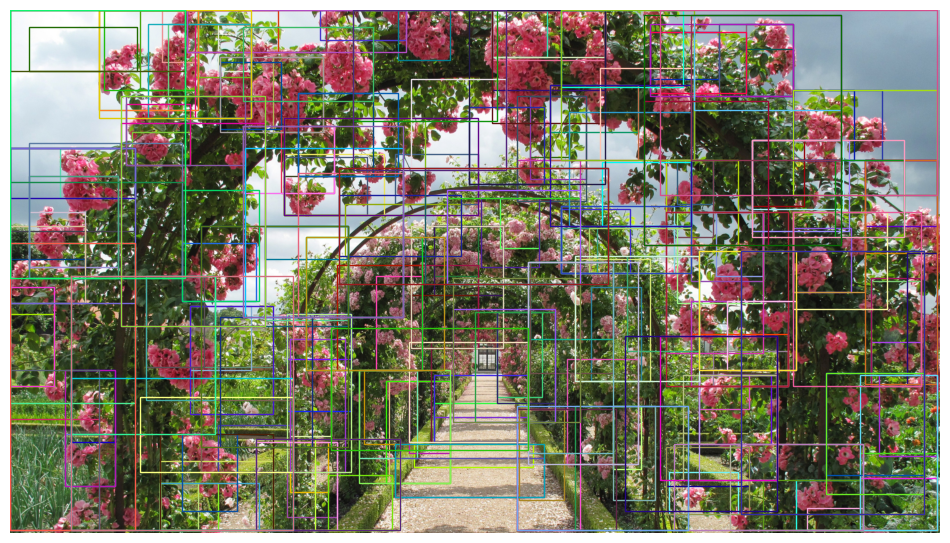

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(img)

for bbox, _ in candidates[-500:]:
    # bbox = candidate['bounding_box']
    y_min, y_max, x_min, x_max = bbox
    h = x_max - x_min
    w = y_max - y_min
    if h*w < 2500:
        continue
    rect = plt.Rectangle((x_min, y_min), h, w, 
                         fill=False, edgecolor=np.random.rand(3,), linewidth=1)
    ax.add_patch(rect)

plt.axis('off')
plt.show()

In [141]:
h_large, w_large = img.shape[:2]

# Crea immagine base
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.imshow(img)

# Sovrapponi tutte le region con colori random
for idx, (bbox, indices) in enumerate(candidates[-15:]):
    # Crea mask per questa region
    mask = np.zeros((h_large, w_large, 3), dtype=float)
    y_coords = indices // w_large
    x_coords = indices % w_large
    
    # Colore random
    random_color = np.random.rand(3)
    mask[y_coords, x_coords] = random_color
    
    # Sovrapponi con alpha
    ax.imshow(mask, alpha=0.3)

ax.set_title(f"All regions overlapped - {len(candidates)} regions")
ax.axis('off')
plt.tight_layout()
plt.show()

MemoryError: Unable to allocate 8.07 MiB for an array with shape (1260, 2240, 3) and data type bool

Error in callback <function _draw_all_if_interactive at 0x0000012758607060> (for post_execute), with arguments args (),kwargs {}:


MemoryError: Unable to allocate 43.1 MiB for an array with shape (1260, 2240, 4) and data type float32

Error in callback <function flush_figures at 0x000001276DE90F40> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 